In [1]:
import os
import pickle
from dotenv import load_dotenv
load_dotenv()

import cvxpy as cp
import geopandas as gpd
import networkx as nx
import numpy as np
import osmnx as ox

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import random

from sodapy import Socrata

pd.set_option("display.max_columns", 1000)

(CVXPY) Nov 29 11:52:35 AM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <EA245032-41C7-30EA-BA1A-C55492696949> /Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so\n  Reason: tried: '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/lib/python3.10/site-packages/../../liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/bin/../lib/liblapack.3.dylib' (no such file), '/Users/kimsha/anaconda3/envs/ev-load-forecast-nyc/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in d

# Matrix Completion: Chelsea

## Data Collection

### GeoJSON Data

In [2]:
# Get shaply value from geojson
polygon = gpd.read_file('chelsea_network.geojson').to_crs(4326)['geometry'][0]

# Create graph from Open Street Map based on graph, Include travel time over edges
G = ox.add_edge_travel_times(ox.add_edge_speeds(ox.graph_from_polygon(polygon, network_type='drive', simplify=True)))

## The current method of just using osmnx to get the lines is not granular enough so we need to refilter the graph with gpd
# Creates dataframes based on nodes and edges
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# Remove edges outside of polygon
edges_gdf = edges_gdf[edges_gdf.geometry.within(polygon) == True]

<Axes: >

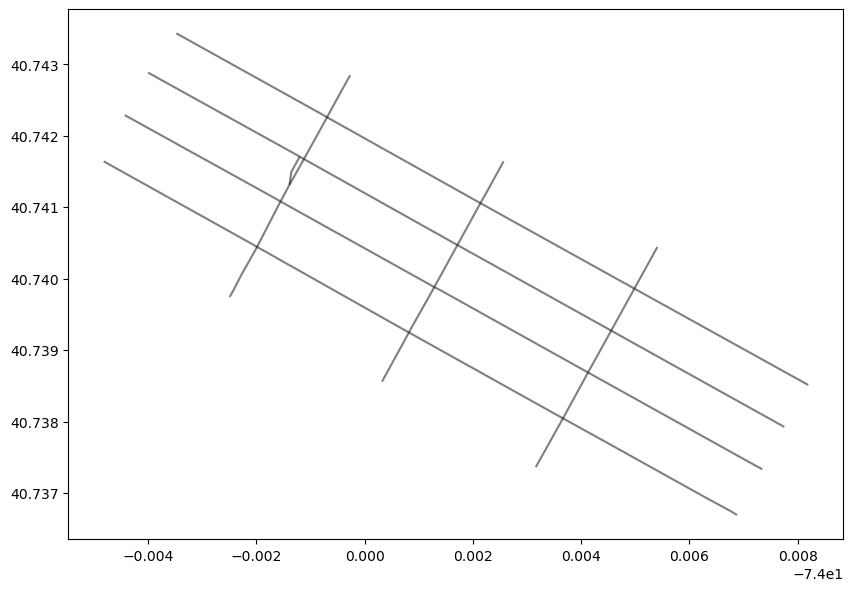

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
edges_gdf.plot(ax=ax, color='black', alpha=0.5)

### ATR Data

In [4]:
APP_TOKEN = os.getenv('APP_TOKEN')
client = Socrata('data.cityofnewyork.us', APP_TOKEN)
def request_atr_series(ids):
    endpoint = "7ym2-wayt"

    query = "SELECT COUNT(*)"

    NUM_RECORDS = int(client.get(endpoint, query=query)[0]['COUNT'])
    
    query = f"""
        SELECT *
        WHERE segmentid IN ({', '.join(map(str, ids))})
        AND yr = 2019
        LIMIT {NUM_RECORDS}
    """
    
    df = pd.DataFrame.from_records(client.get(endpoint, query=query))

    df['ts'] = pd.to_datetime(df[['yr', 'm', 'd', 'hh', 'mm']]\
                 .apply(lambda row: '-'.join(row), axis=1), format='%Y-%m-%d-%H-%M')
    df = df.astype({'vol':float})   
    
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df.wktgeom, crs="ESRI:102718")).drop(columns=['wktgeom'])
    gdf = gdf.to_crs(4326)
    
    gdf['segment_direction'] = df.segmentid + '-' + df.direction
    
    return gdf

atrs_gdf = request_atr_series([32462, 32285,
                         32467, 32814,
                         32811, 32798, 32795,
                         32628, 32634, 32632,
                         32460, 32458, 271225,
                         32299, 32301, 32463])

## Joining Data

In [5]:
# match our ATR data (df) to the closest street segment in the OSMNX graph (gdf_edges)
atrs_with_streets_gdf = atrs_gdf.to_crs(3857).sjoin_nearest(
    edges_gdf.reset_index().to_crs(3857), distance_col='dist', how='inner'
).drop(columns=['index_right']).to_crs(4326).rename(columns={'geometry':'atr_geometry'}).set_geometry('atr_geometry')

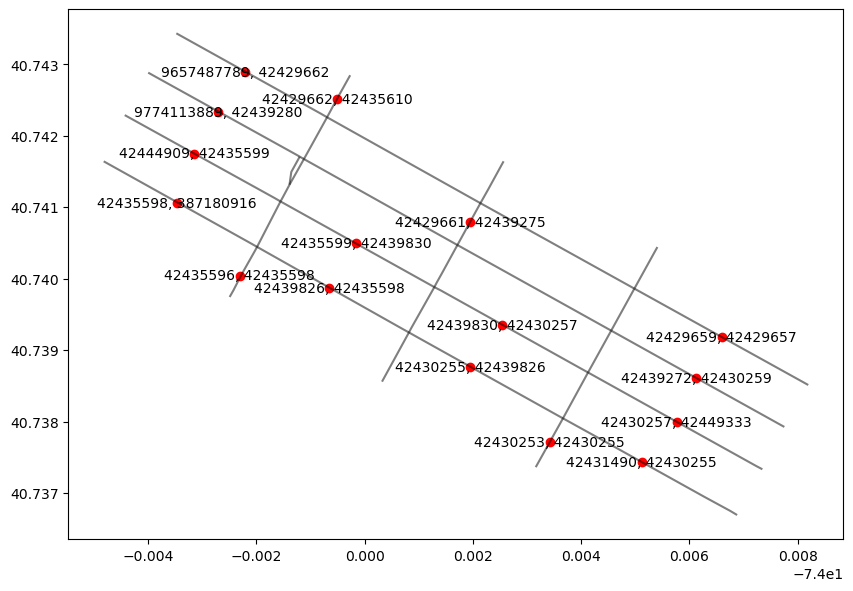

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
edges_gdf.plot(ax=ax, color='black', alpha=0.5)
unique_atr_gdf = atrs_with_streets_gdf.dissolve(by=['u','v','key'], as_index=False)
unique_atr_gdf.plot(ax=ax, color='red')

for idx, row in unique_atr_gdf.iterrows():
    plt.annotate(text= str(row['u']) + ', ' + str(row['v']), xy=row['atr_geometry'].coords[0], horizontalalignment='center',
                 verticalalignment='center')

## Graph Simplification

Due to computational constraints, we're going to simplify this network into a set of source / sink edges, and a primary "central" edge which contains all of the parking capacity contained within the core network

In [7]:
inbound_atrs_lst = {
    '14st_8av': ('42435596','42435598'),
    '16st_8av':('42444909','42435599'),
    '18st_8av':('9657487789','42429662'),
    '14st_6av':('42430253','42430255'),
    '15st_6av':('42431490','42430255'),
    '17st_6av':('42439272','42430259'),
    # NONE
    '19st_7av': ('19st_7av','inbound_central')
}
outbound_atrs_lst = {
    '15st_8av':('42435598','387180916'),
    '17st_8av':('9774113889','42439280'),
    '19st_8av':('42429662','42435610'),
    '18st_6av':('42429659','42429657'),
    '16st_6av':('42430257','42449333'),
    # NONE
    '14st_7av':('outbound_central','14st_7av'), 
    '19st_6av':('outbound_central','19st_6av')
}

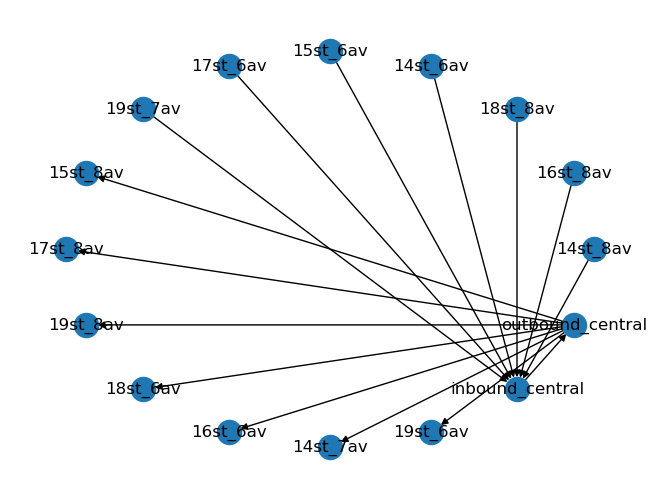

In [8]:
G = nx.DiGraph()

G.add_nodes_from(inbound_atrs_lst.keys())
G.add_nodes_from(outbound_atrs_lst.keys())
G.add_nodes_from(['inbound_central','outbound_central'])

for key, value in inbound_atrs_lst.items():
    G.add_edge(key, 'inbound_central', uv = value)
for key, value in outbound_atrs_lst.items():
    G.add_edge('outbound_central', key, uv = value)

G.add_edge('inbound_central', 'outbound_central')

# temporarily sufficient way to visualize the directed graph - spring layout looks wack
nx.draw_circular(G, with_labels=True)

In [9]:
all_source_sink = {v: k for k, v in nx.get_edge_attributes(G, 'uv').items()}

### Transform Flow

dataframe with a row for each edge. columns is time stamps

In [10]:
# # Let's work with the window with least missingness for now
# window = '1D'
# chosen_date = atrs_with_streets_gdf.groupby(pd.Grouper(key='ts', freq=window)).size().idxmax().date()
# chosen_date

In [11]:
atrs_with_streets_gdf.ts.dt.date.sort_values().unique()

array([datetime.date(2019, 10, 18), datetime.date(2019, 10, 19),
       datetime.date(2019, 10, 20), datetime.date(2019, 10, 21),
       datetime.date(2019, 10, 22), datetime.date(2019, 10, 23),
       datetime.date(2019, 10, 24), datetime.date(2019, 10, 25),
       datetime.date(2019, 10, 26), datetime.date(2019, 10, 27),
       datetime.date(2019, 10, 28), datetime.date(2019, 10, 29),
       datetime.date(2019, 10, 30), datetime.date(2019, 10, 31)],
      dtype=object)

In [12]:
# Combine u, v (origin-destination) IDs
# flow_df = atrs_with_streets_gdf[atrs_with_streets_gdf.ts.dt.date == chosen_date].copy()
flow_df = atrs_with_streets_gdf.copy()
flow_df['u,v'] = flow_df.apply(lambda x: (str(x['u']), str(x['v'])), axis = 1)

In [13]:
flow_df = flow_df.groupby(['u,v', pd.Grouper(key='ts', freq='H')]).vol.sum().reset_index()

In [14]:
# Unstack and filter u, v to ATRs included in the simplified graph
flow_df = flow_df.pivot(columns = 'ts', index = 'u,v', values = 'vol')
flow_df = flow_df[flow_df.index.isin(all_source_sink.keys())]
# map to labels created for the networkx graph
flow_df.index = flow_df.index.map(all_source_sink)

In [15]:
# Add in edges that are completely missing ATR data
flow_df = pd.concat([
    flow_df, pd.DataFrame(index=list(set(G.edges) - set(flow_df.index)), columns=flow_df.columns)
]).sort_index()
flow_df.shape

/var/folders/42/qlm4zcmj6jb69bb7c3htqswc0000gn/T/ipykernel_34867/1392185178.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  flow_df = pd.concat([


(15, 300)

## Matrix Completion

### Formulation

**Variables**:
- $G(V,E)$ is a network (graph) where the nodes/vertices ($V$) represent road intersections and the links/edges ($E$) represent the street segments.
- $F_{\text{in}}(u, v, t)$: Number of vehicles flowing into edge $(u, v)$ over time interval starting at $t$.
- $F_{\text{out}}(u, v, t)$: Number of vehicles flowing out of edge $(u, v)$ over time interval starting at $t$.
- $P(u, v, t)$: Number of vehicles parked on road segment / edge $(u, v)$ at time $t$ (start of the time interval).

**Objective Function**:

$$
\begin{align}
\text{minimize }||\Omega_{\text{in}} \odot (F_{\text{in}} - F_{\text{in}}^c||_F^2 \\
+ ||\Omega_{\text{out}} \odot (F_{\text{out}} - F_{\text{out}}^c)||_F^2 \\
+ \lambda_1||F_{\text{in}}L'F_{\text{out}}||_F \\
+ \lambda_2||F_{\text{out}}L'F_{\text{in}}||_F \\
+ \lambda_3||F_{\text{in}}(:, t+1) - F_{\text{in}}(:, t)||_F \\
+ \lambda_4||F_{\text{out}}(:, t+1) - F_{\text{out}}(:, t)||_F \\
+ \lambda_5||F_{\text{in}} - F_{\text{out}}||_F
\end{align}
$$

**Constraints**:
1. **Parking Change Consistency**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}(u, v, t) - F_{\text{out}}(u, v, t) = P(u, v, t+1) - P(u, v, t) = \delta P(u, v, t)
$$

2. **Flow Conservation** (around *interior* intersections):

For each edge $(u, v)$ and time interval starting at $t$: the inflow into an edge $(u, v)$ over time interval starting at $t$ must be equal to the sum of outflow from edges incident on the origin $u$ (i.e., edges **going into** intersection $u$), minus the sum of inflow into other edges that share the same origin $u$ (but **different** $v$) over that same interval.

$$
F_{\text{in}}(u, v, t) = \sum_{\forall w \text{; } \exists (w, u) \in E} F_{\text{out}}(w, u, t) - \sum_{\forall w \text{; } \exists (u, w) \in E \text{; } w \neq v} F_{\text{in}}(u, w, t)
$$

$$
F_{\text{in}}(:, t) = A'^\intercal \cdot F_{\text{out}}(:, t) - O \cdot F_{\text{in}}(:, t)
$$
- Where $O$ is an "outgoing" matrix constructed from the incidence matrix $M$ that indicates for each edge $(u, v)$, all the ***other*** edges that share the same origin $u$.
- This balance can only be applied to edges for which the origin is fully characterized (i.e., we know all the connected edges to that origin). Therefore, it cannot be applied to the outer edges on the boundaries of the network that are "sources" of flow into the whole network.

3. **Non-negativity**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}^c(u, v, t) \geq 0, \quad F_{\text{out}}^c(u, v, t) \geq 0
$$

4. **Integer Constraints**:
For each edge $(u, v)$ and time $t$:

$$
F_{\text{in}}^c(u, v, t) \in \mathbb{Z}, \quad F_{\text{out}}^c(u, v, t) \in \mathbb{Z}
$$

### Variables

**Decision Variables**

In [16]:
# Decision Variables
F_in = flow_df.copy()
F_in.loc[:, 'inbound_central', :] = np.nan
F_in = F_in.fillna(-1).to_numpy()
print('F_in:', F_in.shape)

F_out = flow_df.copy()
F_out.loc['outbound_central', :, :] = np.nan
F_out = F_out.fillna(-1).to_numpy()
print('F_out:', F_out.shape)

# Net parking state matrix at time 0 (i.e., initial number of parked cars)
P0 = np.zeros((F_in.shape[0], 1))
print('P0:', P0.shape)

F_in: (15, 300)
F_out: (15, 300)
P0: (15, 1)


**Masks**

In [17]:
# Omegas are binary matrices (with the same dimensions as F_in and F_out, respectively) where each element indicates whether the corresponding element in F_in / F_out is known (1) or unknown (0).
def indicator_function(arr):
    indicator_arr = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i, j] != -1:
                indicator_arr[i, j] = 1
            else:
                indicator_arr[i, j] = 0
    return indicator_arr

omega_in = indicator_function(F_in)
omega_out = indicator_function(F_out)

In [18]:
# Track primal graph
G_prime=nx.line_graph(G)

L_prime = nx.directed_laplacian_matrix(G_prime, nodelist=list(flow_df.index))
A_prime = nx.adjacency_matrix(G_prime, nodelist=list(flow_df.index)).todense()

In [19]:
# The incidence matrix assigns each row to a node and each column to an edge.
# -1: the source (tail) of an edge
# 1: the destination (head) of the edge
M = nx.incidence_matrix(G, nodelist=list(G.nodes), edgelist=list(flow_df.index), oriented=True).todense()

# Let's construct O using the incidence matrix:
M_in = np.where(M == -1, 1, 0)

# For each edge in M (columns), identify the node where the edge originates from,
# and then append the row of all other edges that share the same origin node
O = []
for e in M_in.T:
    idx = np.argmax(e)
    O.append(M_in[idx])
O = np.array(O)

# subtract the identity matrix to ensure that the edge itself is not counted in its outflow.
O = O - np.eye(len(G.edges), len(G.edges))

Because the flow conservation constraint can only be applied to edges for which the origin is fully characterized (i.e., we know all the connected edges to that origin). In practice, we shall construct a binary "mask" that zeroes out rows pertaining to edges that shouldn't be included in this constraint:

In [20]:
# Create a mask that will be multipled (element-wise) against the matrices in the flow conservation constraint
mask = np.ones_like(F_in)
for idx, e in enumerate(flow_df.index):
    if len(G.in_edges(e[0])) == 0:
        mask[idx, :] = 0

### Implementation

In [21]:
def complete_matrix(omega_in, omega_out,
                    F_in, F_out, P0, L_prime, A_prime, O, mask,
                    lambdas = [0.2, 0.2, 0.2, 0.2, 0.2]):
    """
    Solve optimization with CVXPY - Gurobi for matrix completion task

    omega_in : numpy 2D array
        Binary matrix indicating whether an element in F_in is known (1) or unknown (0).    
    omega_out : numpy 2D array
        Binary matrix indicating whether an element in F_out is known (1) or unknown (0).  
    F_in : numpy 2D array
        Inflow matrix
    F_out : numpy 2D array
        Outflow matrix
    L_prime : numpy 2D array
        Laplacian of the dual graph
    A_prime : numpy 2D array
        Adjacency matrix of the dual graph
    mask : numpy 2D array
        Binary matrix that zeroes out rows for edges to be excluded in the flow conservation constraint
    lambdas : list
        Regularization parameters that controls the trade-off between fitting
        known elements and promoting a low-rank structure.
    """

    # Decision Variables: completed versions of F_in and F_out matrices, respectively.
    F_in_c = cp.Variable(F_in.shape, integer=False)
    F_out_c = cp.Variable(F_out.shape, integer=False)

    # Define the objective
    expr1 = cp.square(cp.atoms.norm(cp.multiply(omega_in, (F_in - F_in_c)), p='fro'))
    expr2 = cp.square(cp.atoms.norm(cp.multiply(omega_out, (F_out - F_out_c)), p='fro'))
    # expr3 = lambdas[0] * cp.atoms.norm((cp.multiply(omega_in, F_in).T @ L_prime) @ F_out_c, p='fro')
    # expr4 = lambdas[1] * cp.atoms.norm((cp.multiply(omega_in, F_out).T @ L_prime) @ F_in_c, p='fro')
    expr5 = lambdas[2] * cp.atoms.norm(F_in_c[:, 1:] - F_in_c[:, :-1], p='fro')
    expr6 = lambdas[3] * cp.atoms.norm(F_out_c[:, 1:] - F_out_c[:, :-1], p='fro')
    expr7 = lambdas[4] * cp.atoms.norm(F_in_c - F_out_c, p='fro')
    # objective = cp.Minimize(expr1 + expr2 + expr3 + expr4 + expr5 + expr6 + expr7)
    objective = cp.Minimize(expr1 + expr2 + expr5 + expr6 + expr7)

    # Define the constraints
    constraints = [
        F_in_c >= 0,  # Ensure each element of F_in_c is positive
        F_out_c >= 0,  # Ensure each element of F_out_c is positive
        P0 + cp.cumsum(F_in_c - F_out_c, axis=1) >= 0, # Assert positive Parking matrix
        cp.multiply(mask, F_in_c) == cp.multiply(mask, A_prime.T @ F_out_c - O @ F_in_c) # Flow Conservation
    ]
    
    problem = cp.Problem(objective=objective,
                         constraints=constraints)
    
    problem.solve(solver=cp.GUROBI, reoptimize=False)
    print(problem.status)
    
    return F_in_c.value, F_out_c.value

### Optimization

In [22]:
%%time
F_in_c, F_out_c = complete_matrix(omega_in, omega_out, F_in, F_out, P0,
                                  L_prime, A_prime, O, mask,
                                  lambdas = [0.2, 0.2, 0.2, 0.2, 0.2])

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-10
optimal
CPU times: user 2.86 s, sys: 3.07 s, total: 5.93 s
Wall time: 1.25 s


## Sense Checks

In [23]:
pd.DataFrame(F_in_c, index=flow_df.index)

0             1             2    \
14st_6av         inbound_central     298.682737    288.526930    274.701904   
14st_8av         inbound_central     429.392532    419.232658    405.404158   
15st_6av         inbound_central     558.719550    548.559652    534.731131   
16st_8av         inbound_central     208.643956    278.521890    373.841485   
17st_6av         inbound_central     127.571634    117.333384    103.497894   
18st_8av         inbound_central     538.583875    528.424004    514.595503   
19st_7av         inbound_central   85312.555801  85302.396016  85288.567539   
inbound_central  outbound_central  87455.671709  87465.066203  87478.836795   
outbound_central 14st_7av          42914.775486  42916.042431  42917.770023   
                 15st_8av            100.435464    101.710209    103.440336   
                 16st_6av            155.349558    156.620066    158.347215   
                 17st_8av            237.252181    238.517998    240.244404   
                 18st_6av            101.595044    102.866749    104.595976   
                 19st_6av          42914.775486  42916.042431  42917.770023   
                 19st_8av           1028.984451   1030.257466   1031.987860   

                                            3             4             5    \
14st_6av         inbound_central     279.210903    284.702847    326.833321   
14st_8av         inbound_central     409.854865    413.564471    400.830478   
15st_6av         inbound_central     539.181776    542.889805    530.107330   
16st_8av         inbound_central     342.705700    314.609903    330.927143   
17st_6av         inbound_central     107.966338    112.234482    116.681383   
18st_8av         inbound_central     519.046201    522.755732    510.019881   
19st_7av         inbound_central   85293.018240  85296.727976  85283.998789   
inbound_central  outbound_central  87473.488145  87468.980131  87460.847226   
outbound_central 14st_7av          42917.216060  42916.810676  42920.176710   
                 15st_8av            102.882277    102.325186    101.005197   
                 16st_6av            157.791739    157.362176    160.000786   
                 17st_8av            239.689386    239.283256    242.649906   
                 18st_6av            104.033224    103.345152     98.009690   
                 19st_6av          42917.216060  42916.810676  42920.176710   
                 19st_8av           1031.434798   1031.025772   1034.263709   

                                            6             7             8    \
14st_6av         inbound_central    1704.949532   1732.434227   1581.975353   
14st_8av         inbound_central      92.021766     95.002270    197.628474   
15st_6av         inbound_central     219.805270    177.075646    135.398689   
16st_8av         inbound_central     282.300817    302.417761    293.278732   
17st_6av         inbound_central     336.165210    336.880278    270.996446   
18st_8av         inbound_central     201.154485    202.424244    252.438533   
19st_7av         inbound_central   84975.345746  84976.660602  85027.836331   
inbound_central  outbound_central  87829.497329  87824.691002  87765.288633   
outbound_central 14st_7av          42896.867769  42881.228337  42890.516924   
                 15st_8av            242.994914    226.999090    213.996816   
                 16st_6av            161.000089    173.997617    136.998390   
                 17st_8av            219.381554    204.998644    172.000166   
                 18st_6av            383.989213    327.997299    219.999945   
                 19st_6av          42896.867769  42881.228337  42890.516924   
                 19st_8av           1007.004303   1125.998809   1237.988957   

                                            9             10            11   \
14st_6av         inbound_central    1418.110632   1271.167011    971.446240   
14st_8av         inbound_central     209.593064    215.616173    187.758735   
15st_6av    

In [24]:
pd.DataFrame(F_out_c, index=flow_df.index)

0             1             2    \
14st_6av         inbound_central     297.493978    286.874708    271.499775   
14st_8av         inbound_central     426.488275    415.875625    400.505045   
15st_6av         inbound_central     555.797841    545.185193    529.814604   
16st_8av         inbound_central     203.002717    276.001110    381.994827   
17st_6av         inbound_central     127.556515    117.022559    101.656728   
18st_8av         inbound_central     535.678950    525.066303    509.695723   
19st_7av         inbound_central   85309.653438  85299.040712  85283.670099   
inbound_central  outbound_central  87453.167658  87462.057345  87474.155831   
outbound_central 14st_7av          42914.189437  42915.404088  42916.973360   
                 15st_8av             99.082706    100.291520    101.859376   
                 16st_6av            155.177601    156.390590    157.960775   
                 17st_8av            237.123641    238.341969    239.913253   
                 18st_6av             98.787750    100.001865    101.571495   
                 19st_6av          42914.189437  42915.404088  42916.973360   
                 19st_8av           1027.996983   1029.206965   1030.774284   

                                            3             4             5    \
14st_6av         inbound_central     277.227609    280.219775    231.059758   
14st_8av         inbound_central     406.292349    411.105823    418.011815   
15st_6av         inbound_central     535.601938    540.416991    547.372436   
16st_8av         inbound_central     342.000229    311.001893    335.008358   
17st_6av         inbound_central     107.425622    111.668412    101.018685   
18st_8av         inbound_central     515.483025    520.296555    527.204410   
19st_7av         inbound_central   85289.457380  85294.270688  85301.171769   
inbound_central  outbound_central  87470.263538  87466.962888  87476.282702   
outbound_central 14st_7av          42916.564357  42916.283295  42917.940434   
                 15st_8av            101.455523    101.330568    107.778574   
                 16st_6av            157.553653    157.297794    159.699747   
                 17st_8av            239.505468    239.225297    240.882026   
                 18st_6av            101.172557    101.181080    111.730966   
                 19st_6av          42916.564358  42916.283295  42917.940434   
                 19st_8av           1030.364826   1030.087823   1031.875983   

                                            6             7             8    \
14st_6av         inbound_central    1797.939454   1742.993950   1580.996645   
14st_8av         inbound_central      70.112603     88.001970    203.993606   
15st_6av         inbound_central     200.998547    176.998409    134.997127   
16st_8av         inbound_central     276.991312    303.997606    294.995803   
17st_6av         inbound_central     350.980820    340.996586    270.996788   
18st_8av         inbound_central     179.362828    199.000151    257.994063   
19st_7av         inbound_central   84953.111771  84972.702335  85021.314607   
inbound_central  outbound_central  87808.105605  87822.448126  87762.018117   
outbound_central 14st_7av          42896.677696  42882.292939  42893.026416   
                 15st_8av            233.812229    226.433432    211.036662   
                 16st_6av            161.296072    170.760372    136.672046   
                 17st_8av            219.578159    203.910565    175.153100   
                 18st_6av            363.896781    323.815498    222.974167   
                 19st_6av          42896.677696  42882.292939  42893.026416   
                 19st_8av           1014.649946   1124.385506   1219.215526   

                                            9             10            11   \
14st_6av         inbound_central    1415.002928   1279.986501    954.015908   
14st_8av         inbound_central     210.002069    217.991010    188.007173   
15st_6av    

In [25]:
P = pd.DataFrame(P0 + np.cumsum(F_in_c.round() - F_out_c.round(), axis=1),
                 index=flow_df.index, columns=flow_df.columns)
display(P)
P = P.iloc[7].to_frame('P')

ts                                 2019-10-18 17:00:00  2019-10-18 18:00:00  \
14st_6av         inbound_central                   2.0                  4.0   
14st_8av         inbound_central                   3.0                  6.0   
15st_6av         inbound_central                   3.0                  7.0   
16st_8av         inbound_central                   6.0                  9.0   
17st_6av         inbound_central                   0.0                  0.0   
18st_8av         inbound_central                   3.0                  6.0   
19st_7av         inbound_central                   3.0                  6.0   
inbound_central  outbound_central                  3.0                  6.0   
outbound_central 14st_7av                          1.0                  2.0   
                 15st_8av                          1.0                  3.0   
                 16st_6av                          0.0                  1.0   
                 17st_8av                          0.0                  1.0   
                 18st_6av                          3.0                  6.0   
                 19st_6av                          1.0                  2.0   
                 19st_8av                          1.0                  2.0   

ts                                 2019-10-18 19:00:00  2019-10-18 20:00:00  \
14st_6av         inbound_central                   8.0                 10.0   
14st_8av         inbound_central                  10.0                 14.0   
15st_6av         inbound_central                  12.0                 15.0   
16st_8av         inbound_central                   1.0                  2.0   
17st_6av         inbound_central                   1.0                  2.0   
18st_8av         inbound_central                  11.0                 15.0   
19st_7av         inbound_central                  11.0                 15.0   
inbound_central  outbound_central                 11.0                 14.0   
outbound_central 14st_7av                          3.0                  3.0   
                 15st_8av                          4.0                  6.0   
                 16st_6av                          1.0                  1.0   
                 17st_8av                          1.0                  1.0   
                 18st_6av                          9.0                 12.0   
                 19st_6av                          3.0                  3.0   
                 19st_8av                          3.0                  4.0   

ts                                 2019-10-18 21:00:00  2019-10-18 22:00:00  \
14st_6av         inbound_central                  15.0                111.0   
14st_8av         inbound_central                  17.0                  0.0   
15st_6av         inbound_central                  18.0                  1.0   
16st_8av         inbound_central                   6.0                  2.0   
17st_6av         inbound_central                   2.0                 18.0   
18st_8av         inbound_central                  18.0                  1.0   
19st_7av         inbound_central                  18.0                  1.0   
inbound_central  outbound_central                 16.0                  1.0   
outbound_central 14st_7av                          4.0                  6.0   
                 15st_8av                          7.0                  0.0   
                 16st_6av                          1.0                  1.0   
                 17st_8av                          1.0                  3.0   
                 18st_6av                         14.0                  0.0   
                 19st_6av                          4.0                  6.0   
                 19st_8av                          5.0                  7.0   

ts                                 2019-10-18 23:00:00  2019-10-19 00:00:00  \
14st_6av         inbound_central                  18.0                  7.0   
14st_8av         inbound_central               

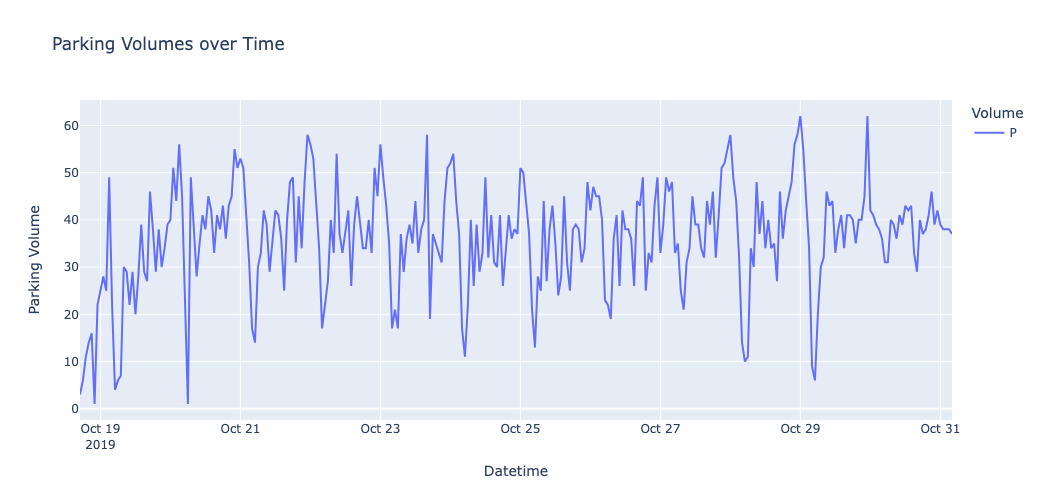

In [26]:
px.line(P, width=1000, height=500,
        labels={'value': 'Parking Volume', 'ts': 'Datetime', 'variable':'Volume'},
        title='Parking Volumes over Time')

Text(0.5, 1.0, 'Parking Volumes over Time')

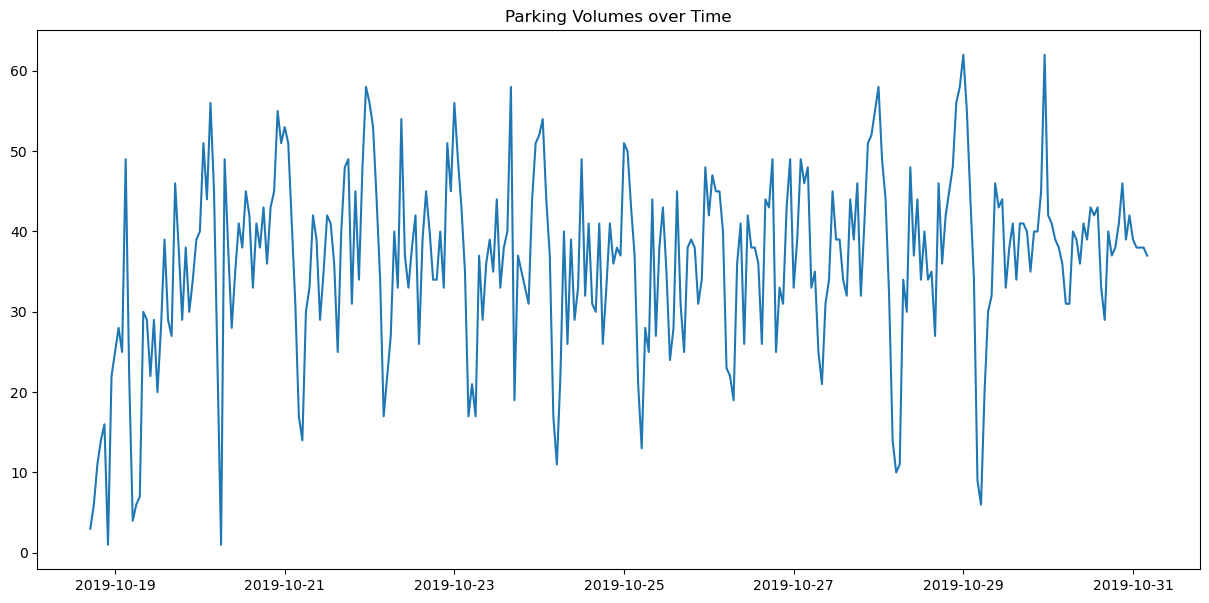

In [27]:
plt.figure(figsize=(15, 7))
plt.plot(P)
plt.title('Parking Volumes over Time')

In [28]:
pickle.dump(P, open('../../data_transformed/chelsea_parking_vol.pkl', 'wb'))